In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tkinter as tk
import tkinter.filedialog as fd

In [4]:
#filename = askopenfilename() # Browse for file
root = tk.Tk()
filez = fd.askopenfilenames(parent=root, title='Choose files')

In [5]:
X = pd.DataFrame()
Y = pd.DataFrame()
for value in iter(filez):
    df = pd.read_csv(value) # Store data in file
    X_read = df[:-1]
    Y_read = pd.DataFrame(np.array([df["GLUCOSE CONC"][1:], 
                           df["GLUTAMINE CONC"][1:], 
                           df["AMMONIA CONC"][1:], 
                           df["INHIBITOR SAT"][1:], 
                           df["TOTAL CELL DENSITY"][1:], 
                           df["VIABLE CELL DENSITY"][1:], 
                           df["DEAD CELL DENSITY"][1:], 
                           df["INHIBITOR SAT"][1:]]).T)
    X = pd.concat([X,X_read], ignore_index=True)
    Y = pd.concat([Y,Y_read], ignore_index=True)

idx = np.random.permutation(X.index)
def df_reindex(df1,idx):
    df1_temp = df1
    return df1_temp.reindex(idx)

X_randomized = df_reindex(X,idx)
Y_randomized = df_reindex(Y,idx)
print(X_randomized.shape)
print(Y_randomized.shape)

(6474, 30)
(6474, 8)


In [6]:
def normalize_mat(mat0):
    m = mat0[0].shape[0]
    def inner_f(mat,acc):
        for array in iter(mat):
            temp_mat = acc
            sig = (1/m)*np.sum(np.square(array))
            mean = (1/m)*np.sum(array)
            remove_mean = array - mean
            normalized_array = remove_mean / (sig + 10**-10)
            temp_mat.append(normalized_array)
            acc = temp_mat   
        return acc
    return np.array(inner_f(mat0,[]))

X_norm = normalize_mat(np.array(X_randomized))
Y_norm = normalize_mat(np.array(Y_randomized))
print(X_norm.shape)
print(Y_norm.shape)

(6474, 30)
(6474, 8)


In [ ]:
# Convert NumPy arrays to PyTorch tensors
X_train_numpy, X_val_numpy, y_train_numpy, y_val_numpy = train_test_split(X_norm, Y_norm, test_size=0.2, random_state=42)

# Ensure NumPy arrays and check shapes
X_train_numpy = np.array(X_train_numpy)
y_train_numpy = np.array(y_train_numpy)
print(X_train_numpy.shape)
print(y_train_numpy.shape)
print(X_val_numpy.shape)
print(y_val_numpy.shape)

# Create DataLoader for batch processing
train_dataset = TensorDataset(torch.tensor(X_train_numpy, dtype=torch.float32), torch.tensor(y_train_numpy, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
X_val = torch.tensor(X_val_numpy, dtype=torch.float32)
y_val = torch.tensor(y_val_numpy, dtype=torch.float32)

In [ ]:
# Define the neural network architecture
class NeuralNetworkRegression(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetworkRegression, self).__init__()
        layers = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        for i in range(1, len(layer_sizes)):
            layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
            if i < len(layer_sizes) - 1:
                layers.append(nn.ReLU())  # Use ReLU activation for hidden layers
        # No activation function on the final output layer for regression
        layers[-1] = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # Use sigmoid activation for binary classification

In [ ]:

# Instantiate the neural network
input_size = X_train_numpy.shape[1]
hidden_sizes = [10,100,1000,176, 1000, 32]  # Adjust the hidden layer sizes as needed
output_size_regression = 8  # For binary classification
model_regression = NeuralNetworkRegression(input_size, hidden_sizes, output_size_regression)

# Define the loss function and optimizer for regression
criterion_regression = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer_regression = optim.Adam(model_regression.parameters(), lr=0.001)

# Lists to store original and predicted values
original_values = []
predicted_values = []

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_regression.train()

    for inputs, targets in train_loader:
        # Forward pass
        outputs = model_regression(inputs)
        loss = criterion_regression(outputs, targets)

        # Backward pass and optimization
        optimizer_regression.zero_grad()
        loss.backward()
        optimizer_regression.step()
    # Validation (optional)
    model_regression.eval()
    with torch.no_grad():
        val_outputs = model_regression(X_val)
        print(X_val.shape)
        print(val_outputs.shape)
        print(y_val.shape)
        val_loss = criterion_regression(val_outputs, y_val)
    # Log the training and validation losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

    # Log original and predicted values
    original_values.extend(y_val_numpy)
    predicted_values.extend(val_outputs.numpy())





(3237, 8)
(3237, 8)
(3237, 8)


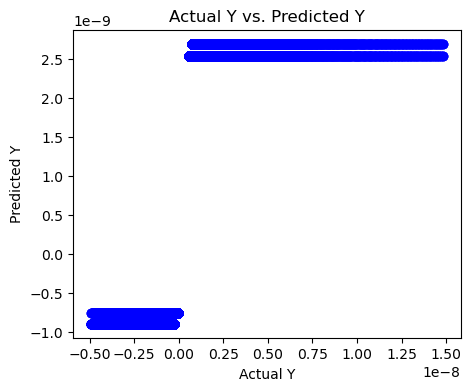

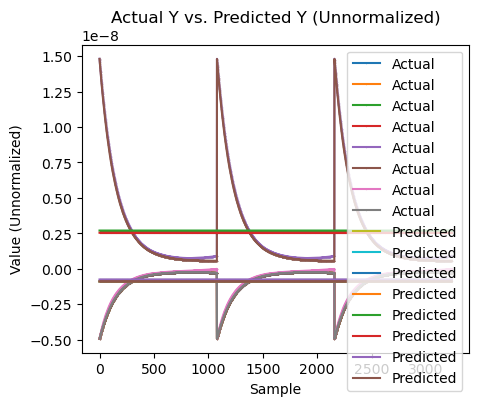

In [12]:
# Plotting the training and validation loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training')
plt.legend()
plt.show()
# Plotting the original vs predicted values
plt.scatter(original_values, predicted_values)
plt.xlabel('Original Values')
plt.ylabel('Predicted Values')
plt.title('Original vs Predicted Values')
plt.show()